In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/四下/ML/HW/hw6

Mounted at /content/drive
/content/drive/MyDrive/四下/ML/HW/hw6


In [2]:
import os
import random
import imageio
from PIL import Image

import numpy as np
from scipy.linalg import eig, eigh
from scipy.spatial.distance import cdist

from matplotlib import pyplot as plt
from matplotlib import colors

## Visualization functions

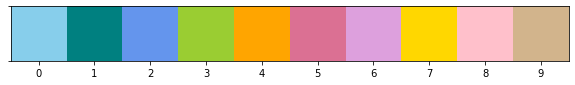

In [7]:
# Color bar
k_color = colors.to_rgba_array(['skyblue','teal','cornflowerblue','yellowgreen','orange','palevioletred','plum','gold','pink', 'tan'])

fig, ax = plt.subplots(figsize=(10,1))
barlist=plt.bar(np.arange(10), np.ones(10), width=1.0)
for i in range(10):
  barlist[i].set_color(k_color[i])

plt.xticks(np.arange(10), np.arange(10))
plt.yticks(np.arange(10), [])
plt.ylim([0, 1])
plt.margins(x=0)
plt.show()


# Bash color
class bashc: # You may need to change color settings
    RED = '\033[91m'
    ENDC = '\033[0m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[34m'
    CYAN  = "\033[96m"

In [8]:
def visualize_clusters(img_records, save_path, figsize=(100, 100, 4)):
    gif = []
    # for each iteration
    for i in range(len(img_records)):
        # Get the cluster of each data point in the current img
        c_id = np.argmax(img_records[i], axis=1)
        n = c_id.shape[0]
        # Colorize each cluster with different colors
        img = np.zeros(figsize, dtype=np.uint8)
        for q in range(100):
            for r in range(100):
                cluster = c_id[q * 100 + r]
                img[q, r] = k_color[cluster] * 255
        gif.append(img)

    plt.axis('off')
    plt.imshow(gif[-1])
    imageio.mimsave(save_path, gif)
    return 

# plot eigenvalues 
def plot_dot(x, y, title):
    plt.scatter(x, y, s=5, marker='o', c='mediumvioletred')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks(np.arange(20), np.arange(20))
    plt.xlim([1, 20])
    plt.ylim([0, y[25]])
    plt.show()

# plot eigenvectors
def visualize_eigvecs(vecs, clusters, k, fig_path):
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    
    n, d = vecs.shape
    # translate clusters from nxk to nx1
    clusters_id = np.argmax(clusters, axis=1)
    for ki in range(k):
        # k_idx : select data within cluster ki
        k_idx = clusters_id == ki
        # visualize using the first 3 axes
        x = vecs[k_idx, 0]
        y = vecs[k_idx, 1]
        if d < 3:
            ax.scatter(x, y, marker='.', c=[k_color[ki]])
        else:
            z = vecs[k_idx, 2]
            ax.scatter(x, y, z, marker='.', c=[k_color[ki]])
    
    plt.savefig(fig_path)
    plt.show(block = False)
    plt.pause(1)
    plt.close()

## Prepare data (Gram matrix)

In [4]:
def read_img(path):
    _img = Image.open(path)
    return np.array(_img.getdata(), dtype=np.uint8)


def new_kernal(x, gamma_s=1e-3, gamma_c=1e-3):
    # dist_s = ||S(x) - S(x')||^2
    grid = np.indices((100, 100)).reshape((2, 10000, 1))
    sx = np.hstack((grid[0], grid[1]))
    ds = cdist(sx, sx, 'sqeuclidean')

    # dist_c = ||C(x) - C(x')||^2
    dc = cdist(x, x, 'sqeuclidean')

    # kenral = e^(-γs ds) * e^(-γs dc)
    kernel = np.exp(-gamma_s * ds) * np.exp(-gamma_c * dc)
    return kernel


# Read images and transform to kernal
kernals = []
for img_path in ['./image1.png', './image2.png']:
    img = read_img(img_path)
    kernal = new_kernal(img)
    kernals.append(kernal)

kernals_e4e3 = []
for img_path in ['./image1.png', './image2.png']:
    img = read_img(img_path)
    kernal = new_kernal(img, gamma_s=1e-4, gamma_c=1e-3)
    kernals_e4e3.append(kernal)

## K-means

In [9]:
class kmeans():
    def __init__(self, data, k=2, method='default', kernal_mode=True):
        self.data = data
        self.k = k
        self.method = method
        self.kernal_mode = kernal_mode
        self.init_centers = self.__kmeanspp if method == 'kmeanspp' else self.__random

    def __random(self):
        idx = list(random.sample(range(0, self.data.shape[0]), self.k))
        return np.array(self.data[idx])

    def __kmeanspp(self):
        n, d = self.data.shape
        centers = np.zeros((self.k, d))
        
        centers[0] = self.data[np.random.randint(n)]
        for i in range(1, self.k):
            # dist to each center
            dist = cdist(self.data, centers[:i], 'sqeuclidean')
            # classify to the closet center
            dist = np.min(dist, axis=1)
            # pick the farest point as center
            centers[i] = self.data[np.argmax(dist, axis=0)]
        return centers

    def __kernal_dist(self, gram, ck):
        n, cnt_k = ck.shape
        dist = np.zeros_like(ck)
       
        # Ck = |Ck|
        Ck = np.sum(ck, axis=0)
        # Sjk = -2/|Ck| * ∑K(xj, xn) with xn∈ck
        Sjk = -2 * (gram @ ck) / Ck
        # Spq = 1/|Ck|^2 * ∑∑K(xp,xq) with xp, xq∈ck
        Spq =  np.ones((n, n)) @ Sjk / (Ck ** 2 + 1e-9)
        
        # distance_jk = K(xj, xj) - 2∑K(xj, xn)/|Ck| + ∑∑K(xp,xq)/|Ck|^2
        for j in range(n):
            for k in range(cnt_k):                
                dist[j, k] = gram[j, j] + Sjk[j, k] + Spq[j, k]
        return dist

    def train(self):
        img_records = []
        converge_iter = 0
        converge = 5

        # 1. Initialization
        n, d = self.data.shape
        # (1) initializa centers
        centers = self.init_centers()
        
        # (2) initialize dist
        dist = cdist(self.data, centers, 'sqeuclidean')
        
        # (3) initialize clusters
        clusters = np.zeros((n, self.k))
        clusters[np.arange(n), np.random.randint(self.k, size=n)] = 1
        img_records.append(clusters)
        # assign data to the closest cluster
        for i in range(n):
            clusters[i, np.argmin(dist[i])] = 1
        img_records.append(clusters)
        
        # 2. Lloyd's algorithm
        for iter in range(100):
            # E-step : classify all samples according to closet μk
            if self.kernal_mode:
                dist = self.__kernal_dist(self.data, clusters)
            else:
                dist = cdist(self.data, centers, 'sqeuclidean')

            # M-step : re-compute the centers μk in cluster Ck
            new_clusters = np.zeros_like(dist)
            for i in range(n):
                new_clusters[i, np.argmin(dist[i])] = 1
            new_centers = (new_clusters.T @ self.data) / (np.sum(new_clusters, axis=0, keepdims=True).T + 1e-9)
            img_records.append(new_clusters)

            # Retrun upon convergence
            delta = np.linalg.norm(new_centers - centers)
            if delta < 1e-10:
                converge -= 1
            if converge == 0:
                converge_iter = iter + 1

            centers = new_centers
            clusters = new_clusters
        
        print(f'k-means : (k = {self.k}, {self.method}) ', bashc.GREEN + f'is converged at iter {converge_iter}' + bashc.ENDC)
        return img_records, converge_iter

## Main : kmeans

k-means : (k = 2, default)  is converged at iter 12
k-means : (k = 2, kmeans++)  is converged at iter 52
-----------------------------------------------------------------------------
k-means : (k = 3, default)  is converged at iter 25
k-means : (k = 3, kmeans++)  is converged at iter 24
-----------------------------------------------------------------------------
k-means : (k = 4, default)  is converged at iter 28
k-means : (k = 4, kmeans++)  is converged at iter 38
-----------------------------------------------------------------------------
k-means : (k = 5, default)  is converged at iter 42
k-means : (k = 5, kmeans++)  is converged at iter 27
-----------------------------------------------------------------------------
k-means : (k = 6, default)  is converged at iter 34
k-means : (k = 6, kmeans++)  is converged at iter 23
-----------------------------------------------------------------------------
k-means : (k = 7, default)  is converged at iter 52
k-means : (k = 7, kmeans++)  is c

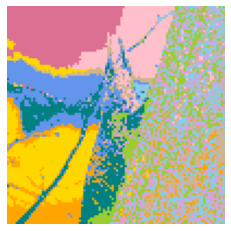

In [10]:
for i, kernal in enumerate(kernals):
    for j in range(9):
        # k = 2 to 10
        k = 2 + j
        
        # kmeans
        model = kmeans(kernal, k, method='default')
        record, _ = model.train()
        visualize_clusters(record, f'output_kmeans/img{i+1}_kmeans(k={k}).gif')
        
        # kmeans++
        model_kpp = kmeans(kernal, k, method='kmeans++')
        record_kpp, _ = model_kpp.train()
        visualize_clusters(record_kpp, f'output_kmeans/img{i+1}_kmeans++(k={k}).gif')

        print('-----------------------------------------------------------------------------')

## Spectral clustering

In [18]:
class spectral_clustering():
    def __init__(self, W , k=2, params={}):
        self.k = k
        self.W = W
        self.D = np.zeros_like(W)
        self.L = np.zeros_like(W)
        self.eig_path = params['root']
        self.train_mode = params['train_mode']
        self.normalize = params['normalized']
        self.kmeans_method = params['kmeans_method']
    
    def __cal_laplacian(self):
        # L = D - W
        self.D = np.diag(np.sum(self.W, axis=1))
        self.L = self.D - self.W

    def __eig(self, L):
        # file pathes
        cut = 'normalized' if self.normalize else 'ratio'
        val_path = f'{self.eig_path}/{cut}_eig_vals_{self.kmeans_method}.npy'
        vec_path = f'{self.eig_path}/{cut}_eig_vecs_{self.kmeans_method}.npy'
        if os.path.isfile(val_path) and os.path.isfile(vec_path):
            self.train_mode = False
        
        # Calculate eig_vals and eig_vecs
        if(self.train_mode):
            # RatioCut
            L = self.L
            # NormalizedCut
            if self.normalize:
                # L = Dsym = D^(-1/2)LD^(-1/2)
                _D = np.zeros_like(self.D)
                for i in range(len(self.D)):
                    _D[i, i] = self.D[i, i] ** -0.5
                L = _D @ self.L @ _D
            
            eig_vals, eig_vecs = np.linalg.eigh(L)
            np.save(val_path, eig_vals)
            np.save(vec_path, eig_vecs)
            return eig_vals, eig_vecs
        # Load eig_vals and eig_vecs from files
        else:
            # Load eig_vals and eig_vecs from files
            eig_vals = np.load(val_path)
            eig_vecs = np.load(vec_path)
            return eig_vals, eig_vecs
    
    def __get_U(self, L, k):
        # 1. Get the eig_vals and eig_vecs
        eig_vals, eig_vecs = self.__eig(L)
        cut = 'normalized' if self.normalize else 'ratio'
        
        # 2. Get the first k non-zero eigenvalues λ
        sort_idx = np.argsort(eig_vals)
        start = 0
        while eig_vals[sort_idx[start]] <= 1e-9:
            start += 1
        k_idx = sort_idx[start : start + self.k]
        # print(f'count of zero λ : {start}, {eig_vals[:10]}')
        # U ∈ R_nk contains k eigenvectors
        U = eig_vecs[:, k_idx]
        lambs = eig_vals[k_idx]
        
        # Normalized U (H'H = I or T'T = I)
        U /= np.linalg.norm(U, axis=1).reshape(-1,1)

        return lambs, U

    def train(self):
        # 1. Calculate Laplacian L
        self.__cal_laplacian()

        # 2. Do eigendecomposition to get eig_vals and eig_vecs
        k_lambs, U = self.__get_U(self.L, self.k)
        
        # 3. For i=1 to n, cluster yi ∈ Rk with k-means algorithm
        km_model = kmeans(U, k=self.k, method=self.kmeans_method, kernal_mode=False)
        img_records, iter = km_model.train()
        return  img_records, k_lambs, U
 

## Main : spectral clustering



### spectral_clustering with kmeans

Spectral_clustering normalizedcut with k = 2
k-means : (k = 2, k)  is converged at iter 9


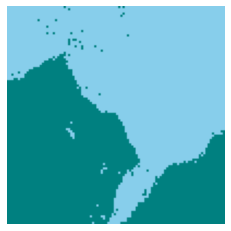

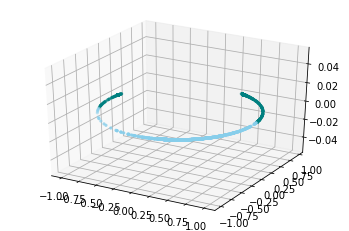

Spectral_clustering ratiocut with k = 2
k-means : (k = 2, k)  is converged at iter 8


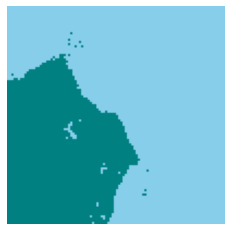

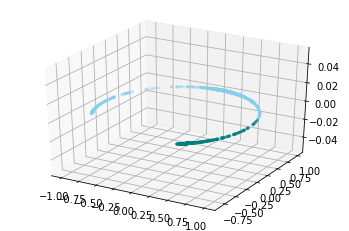


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 3
k-means : (k = 3, k)  is converged at iter 15


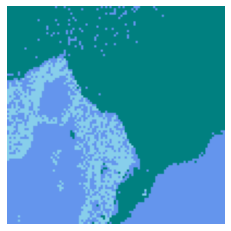

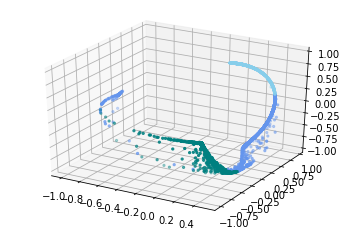

Spectral_clustering ratiocut with k = 3
k-means : (k = 3, k)  is converged at iter 8


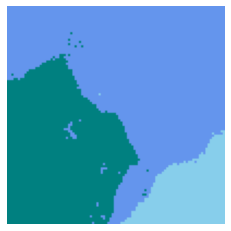

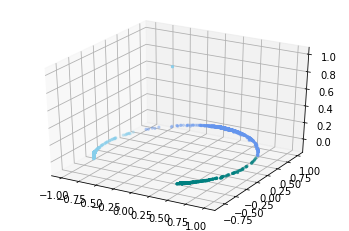


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 4
k-means : (k = 4, k)  is converged at iter 14


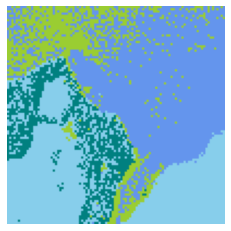

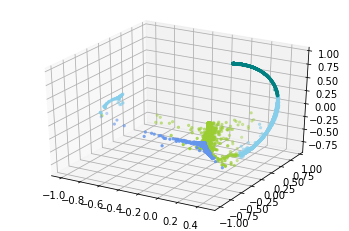

Spectral_clustering ratiocut with k = 4
k-means : (k = 4, k)  is converged at iter 25


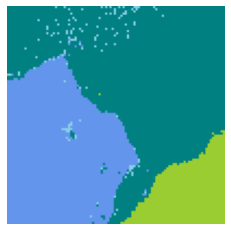

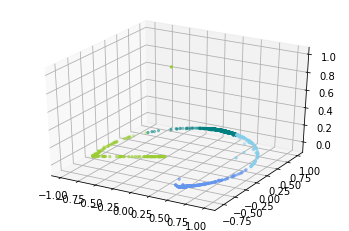


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 5
k-means : (k = 5, k)  is converged at iter 29


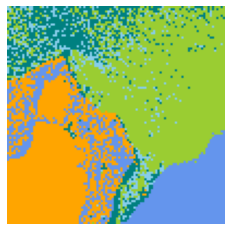

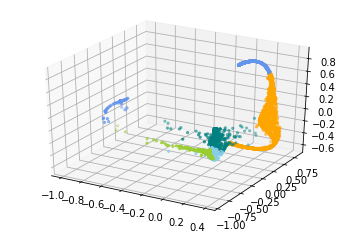

Spectral_clustering ratiocut with k = 5
k-means : (k = 5, k)  is converged at iter 27


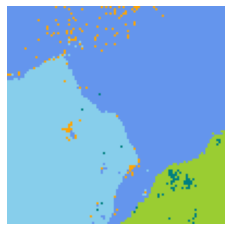

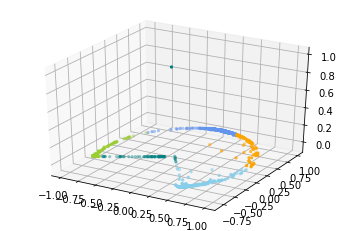


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 6
k-means : (k = 6, k)  is converged at iter 60


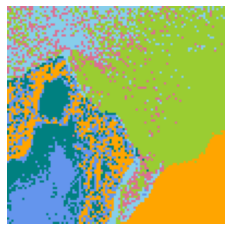

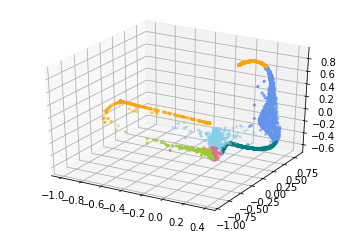

Spectral_clustering ratiocut with k = 6
k-means : (k = 6, k)  is converged at iter 20


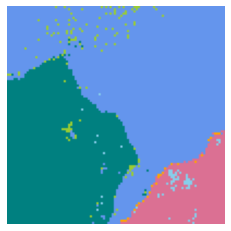

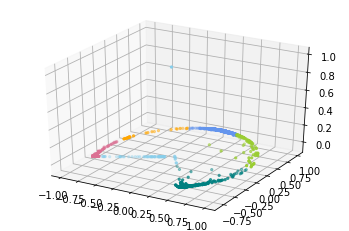


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 7
k-means : (k = 7, k)  is converged at iter 15


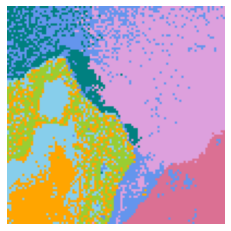

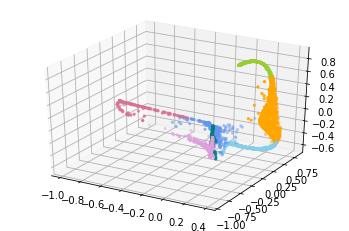

Spectral_clustering ratiocut with k = 7
k-means : (k = 7, k)  is converged at iter 28


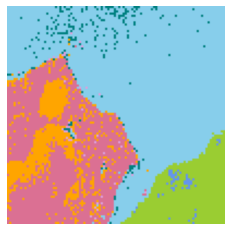

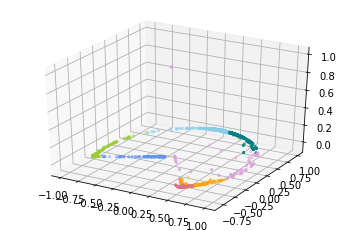


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 8
k-means : (k = 8, k)  is converged at iter 20


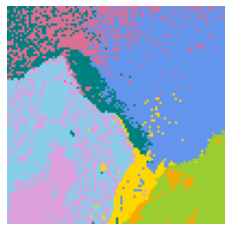

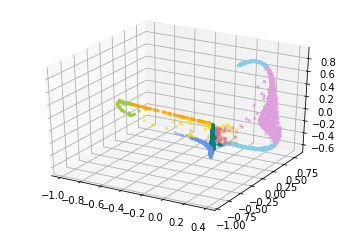

Spectral_clustering ratiocut with k = 8
k-means : (k = 8, k)  is converged at iter 47


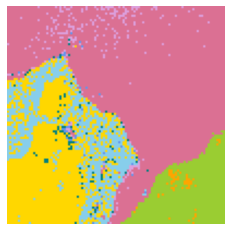

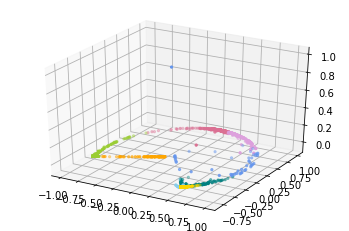


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 9
k-means : (k = 9, k)  is converged at iter 25


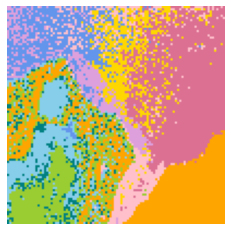

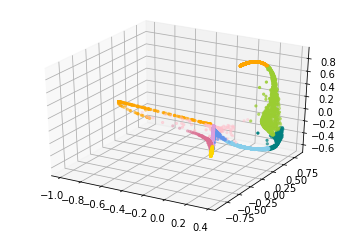

Spectral_clustering ratiocut with k = 9
k-means : (k = 9, k)  is converged at iter 33


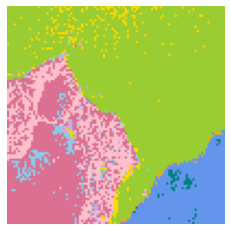

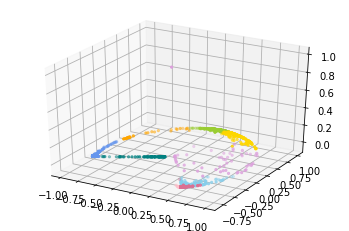


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 10
k-means : (k = 10, k)  is converged at iter 42


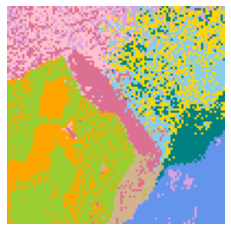

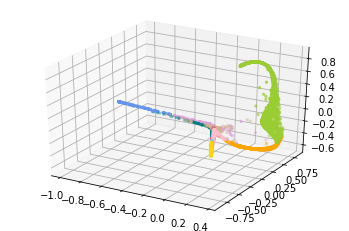

Spectral_clustering ratiocut with k = 10
k-means : (k = 10, k)  is converged at iter 45


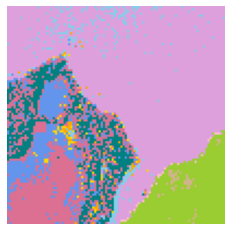

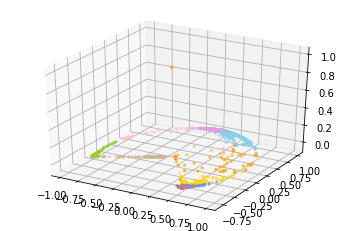


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 2
k-means : (k = 2, k)  is converged at iter 21


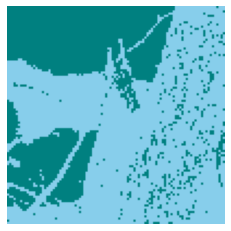

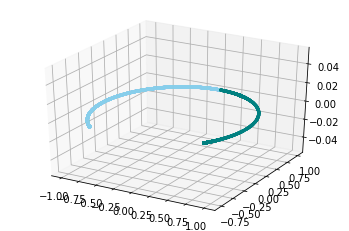

Spectral_clustering ratiocut with k = 2
k-means : (k = 2, k)  is converged at iter 6


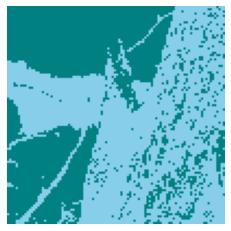

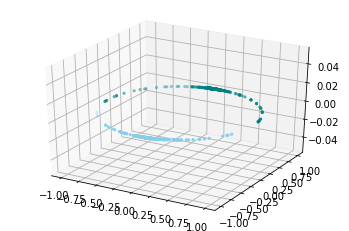


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 3
k-means : (k = 3, k)  is converged at iter 14


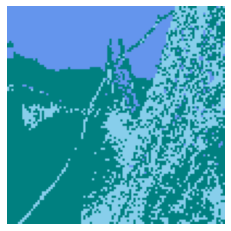

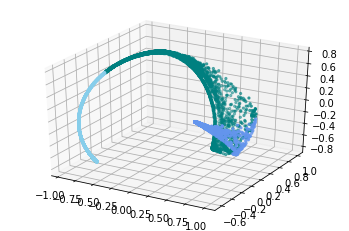

Spectral_clustering ratiocut with k = 3
k-means : (k = 3, k)  is converged at iter 14


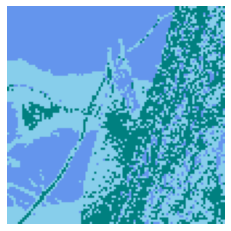

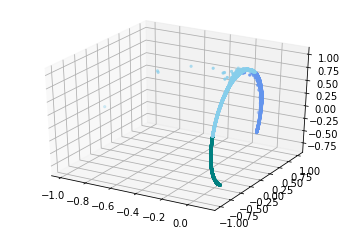


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 4
k-means : (k = 4, k)  is converged at iter 19


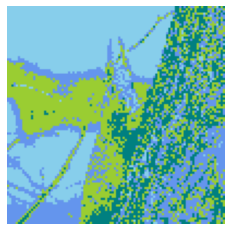

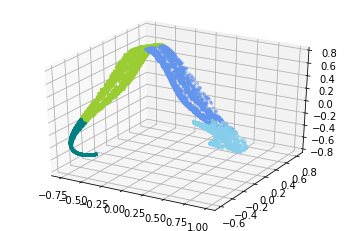

Spectral_clustering ratiocut with k = 4
k-means : (k = 4, k)  is converged at iter 63


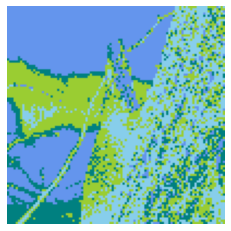

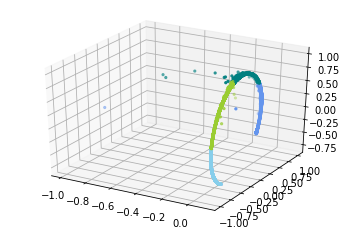


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 5
k-means : (k = 5, k)  is converged at iter 23


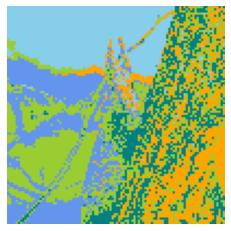

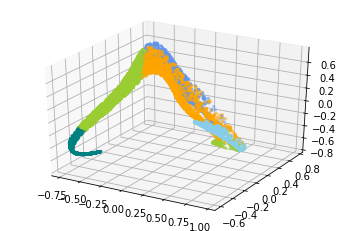

Spectral_clustering ratiocut with k = 5
k-means : (k = 5, k)  is converged at iter 51


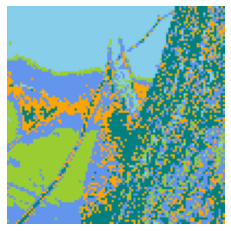

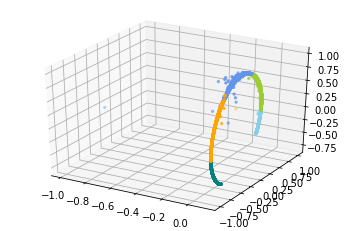


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 6
k-means : (k = 6, k)  is converged at iter 21


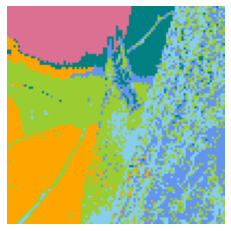

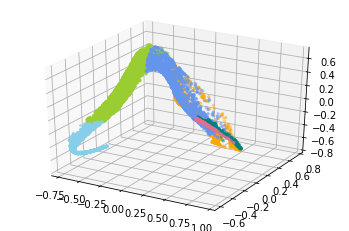

Spectral_clustering ratiocut with k = 6
k-means : (k = 6, k)  is converged at iter 43


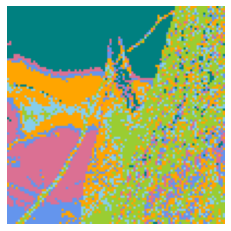

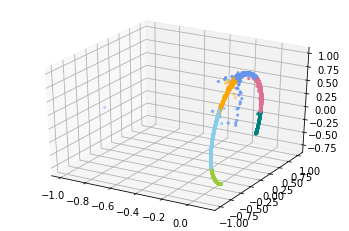


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 7
k-means : (k = 7, k)  is converged at iter 39


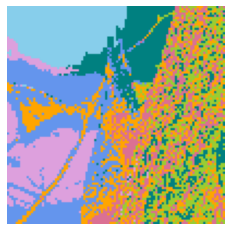

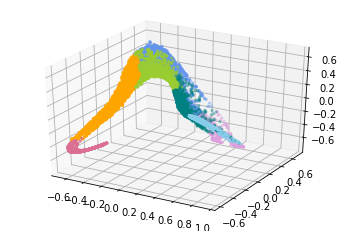

Spectral_clustering ratiocut with k = 7
k-means : (k = 7, k)  is converged at iter 95


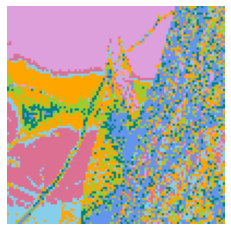

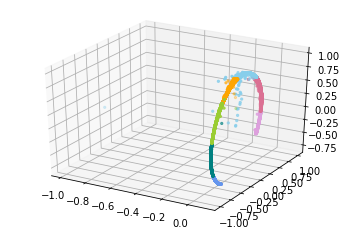


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 8
k-means : (k = 8, k)  is converged at iter 49


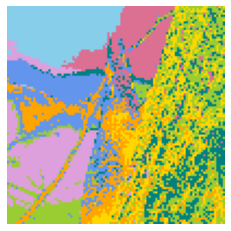

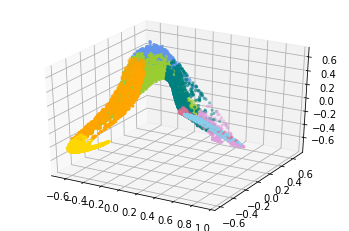

Spectral_clustering ratiocut with k = 8
k-means : (k = 8, k)  is converged at iter 0


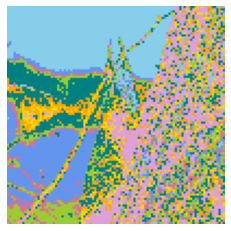

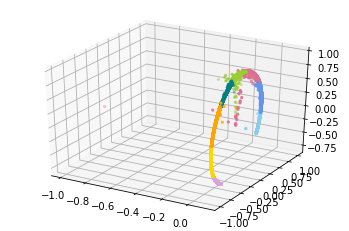


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 9
k-means : (k = 9, k)  is converged at iter 22


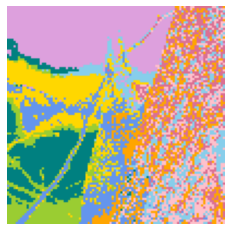

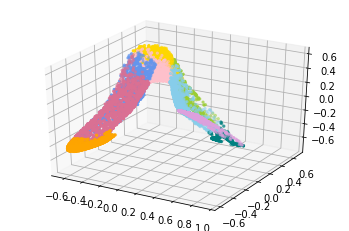

Spectral_clustering ratiocut with k = 9
k-means : (k = 9, k)  is converged at iter 51


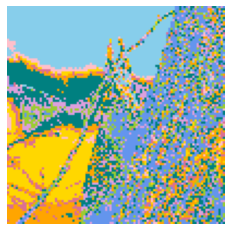

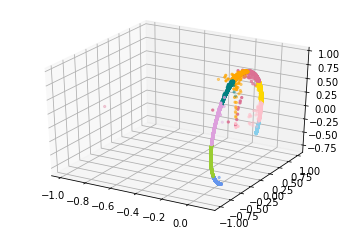


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 10
k-means : (k = 10, k)  is converged at iter 67


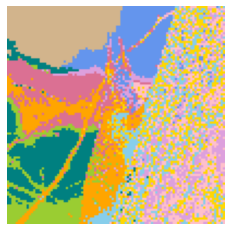

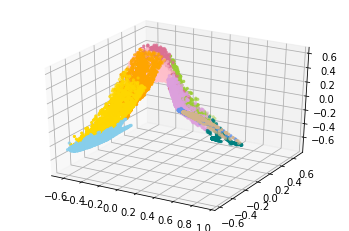

Spectral_clustering ratiocut with k = 10
k-means : (k = 10, k)  is converged at iter 70


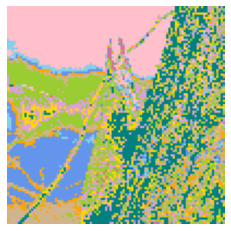

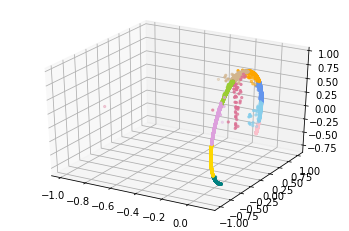


-----------------------------------------------------------------------------



In [11]:
# Select your methods first
# kmeans_method = 'kmeanspp'
kmeans_method = 'k'
train_mode = True
for i, similarity in enumerate(kernals):
    for k in range(2, 11):
        params = {'root': f'img{i+1}',
                  'normalized': False,
                  'train_mode': train_mode,
                  'kmeans_method': kmeans_method}

        for cut_method in ['normalized', 'ratio'] :
            print(bashc.RED + f'Spectral_clustering {cut_method}cut with k = {k}' + bashc.ENDC)
            
            # set the parameters
            params['normalized'] = True if cut_method == 'normalized' else False
            filename = f'output_spectral/img{i+1}_{cut_method}({kmeans_method}={k})'
            # train the model
            model = spectral_clustering(similarity, k, params)
            records, eig_vals, eig_vecs = model.train()
            # visualization
            visualize_clusters(records, filename+'.gif')
            visualize_eigvecs(eig_vecs, records[-1], k, filename+'.png')
        print('\n-----------------------------------------------------------------------------\n')

### spectral clustering with kmeans++

Spectral_clustering normalizedcut with k = 2
k-means : (k = 2, kmeanspp)  is converged at iter 7


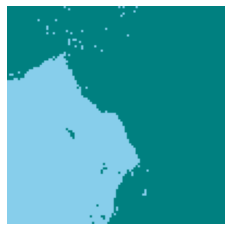

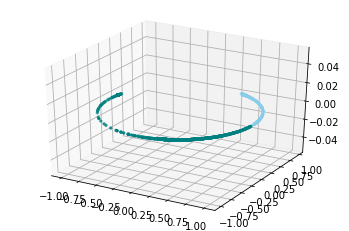

Spectral_clustering ratiocut with k = 2
k-means : (k = 2, kmeanspp)  is converged at iter 8


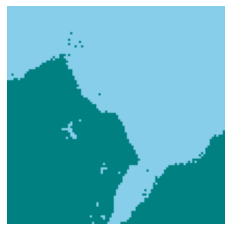

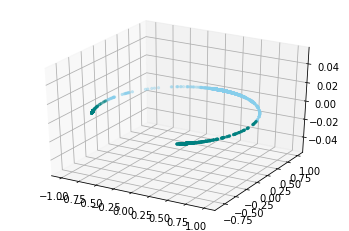


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 3
k-means : (k = 3, kmeanspp)  is converged at iter 9


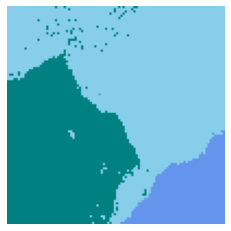

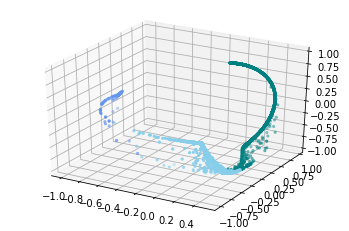

Spectral_clustering ratiocut with k = 3
k-means : (k = 3, kmeanspp)  is converged at iter 7


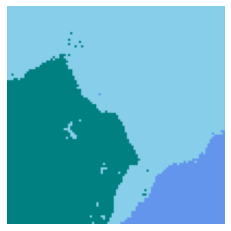

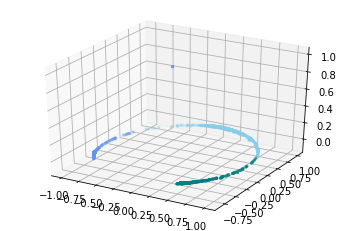


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 4
k-means : (k = 4, kmeanspp)  is converged at iter 10


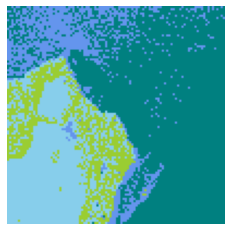

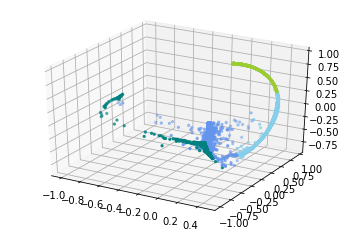

Spectral_clustering ratiocut with k = 4
k-means : (k = 4, kmeanspp)  is converged at iter 11


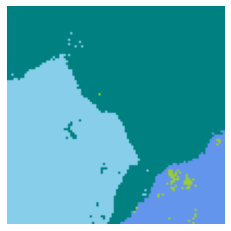

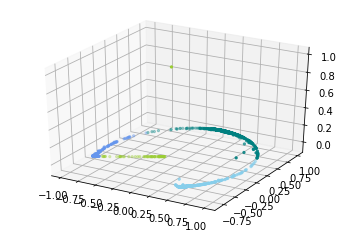


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 5
k-means : (k = 5, kmeanspp)  is converged at iter 13


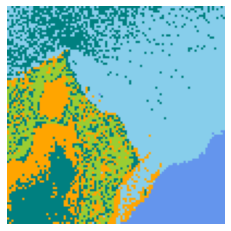

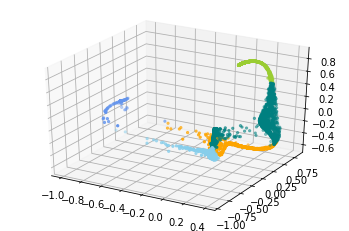

Spectral_clustering ratiocut with k = 5
k-means : (k = 5, kmeanspp)  is converged at iter 13


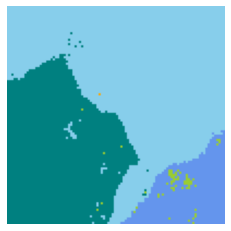

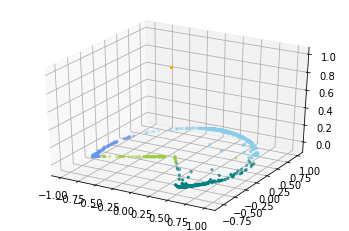


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 6
k-means : (k = 6, kmeanspp)  is converged at iter 17


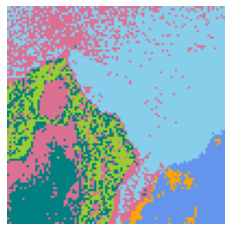

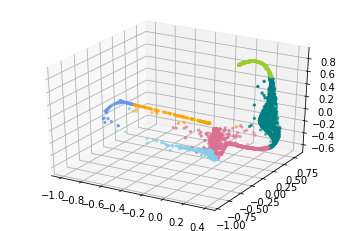

Spectral_clustering ratiocut with k = 6
k-means : (k = 6, kmeanspp)  is converged at iter 11


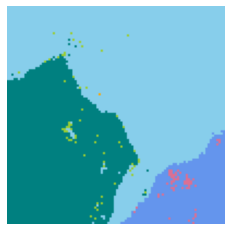

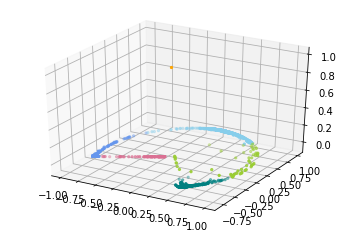


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 7
k-means : (k = 7, kmeanspp)  is converged at iter 15


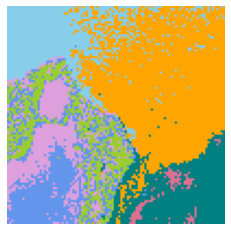

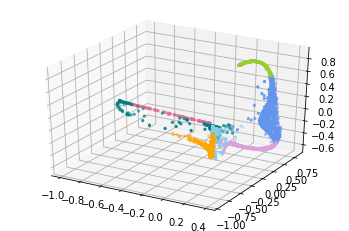

Spectral_clustering ratiocut with k = 7
k-means : (k = 7, kmeanspp)  is converged at iter 33


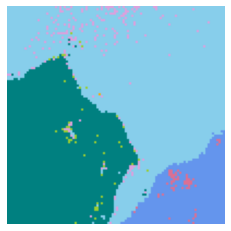

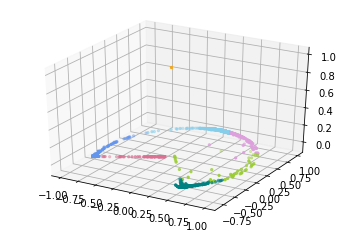


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 8
k-means : (k = 8, kmeanspp)  is converged at iter 14


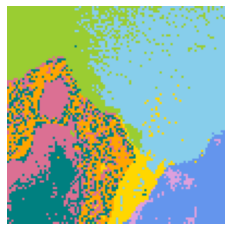

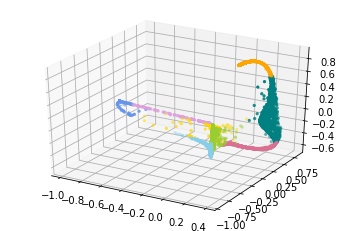

Spectral_clustering ratiocut with k = 8
k-means : (k = 8, kmeanspp)  is converged at iter 29


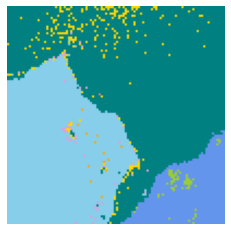

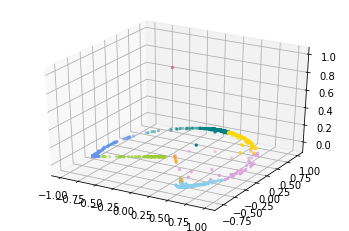


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 9
k-means : (k = 9, kmeanspp)  is converged at iter 13


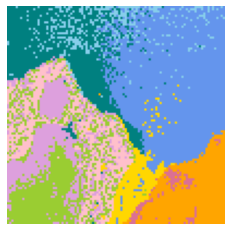

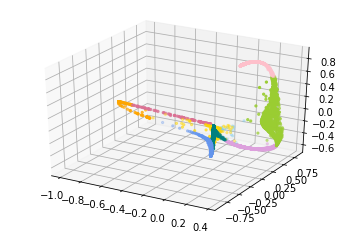

Spectral_clustering ratiocut with k = 9
k-means : (k = 9, kmeanspp)  is converged at iter 18


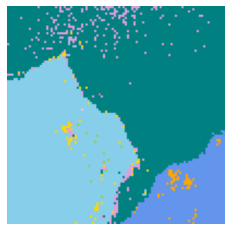

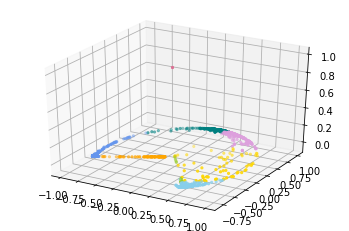


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 10
k-means : (k = 10, kmeanspp)  is converged at iter 80


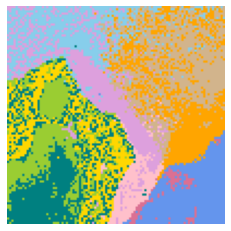

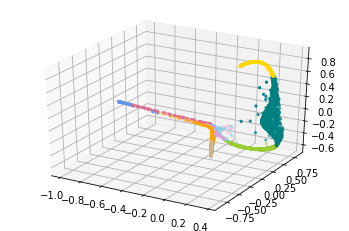

Spectral_clustering ratiocut with k = 10
k-means : (k = 10, kmeanspp)  is converged at iter 34


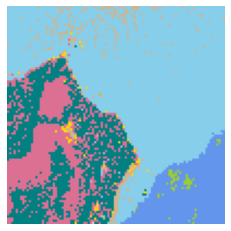

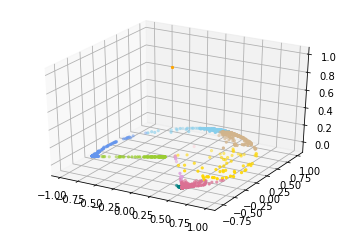


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 2
k-means : (k = 2, kmeanspp)  is converged at iter 18


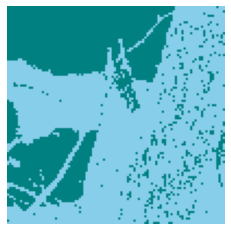

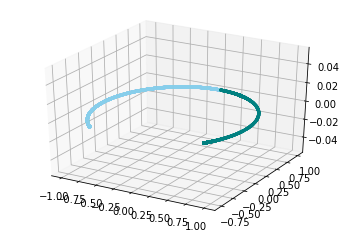

Spectral_clustering ratiocut with k = 2
k-means : (k = 2, kmeanspp)  is converged at iter 6


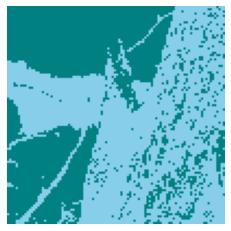

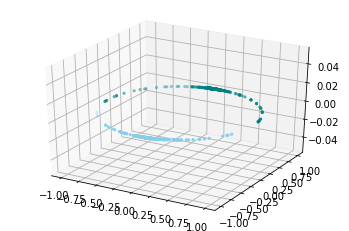


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 3
k-means : (k = 3, kmeanspp)  is converged at iter 16


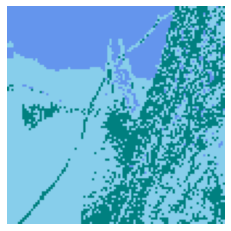

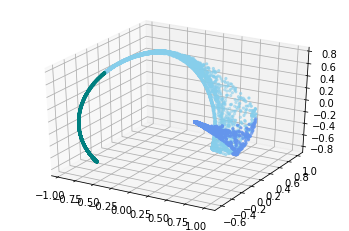

Spectral_clustering ratiocut with k = 3
k-means : (k = 3, kmeanspp)  is converged at iter 15


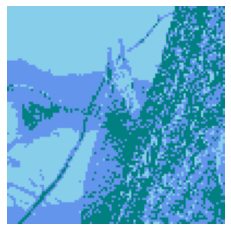

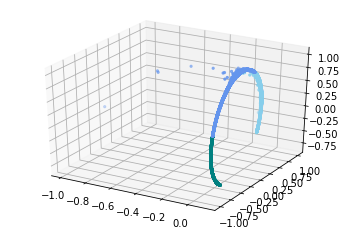


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 4
k-means : (k = 4, kmeanspp)  is converged at iter 17


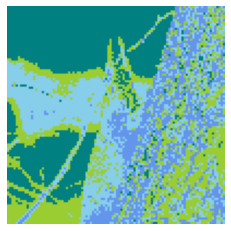

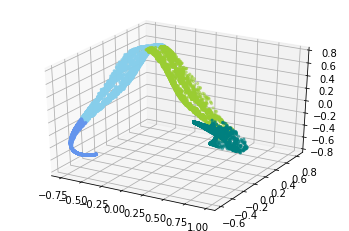

Spectral_clustering ratiocut with k = 4
k-means : (k = 4, kmeanspp)  is converged at iter 10


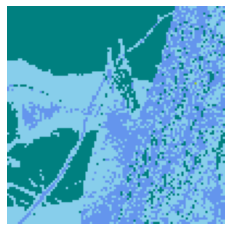

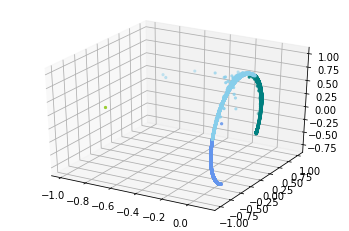


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 5
k-means : (k = 5, kmeanspp)  is converged at iter 29


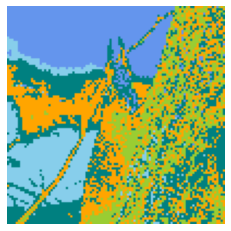

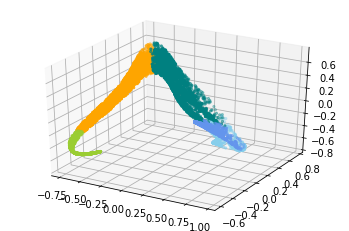

Spectral_clustering ratiocut with k = 5
k-means : (k = 5, kmeanspp)  is converged at iter 65


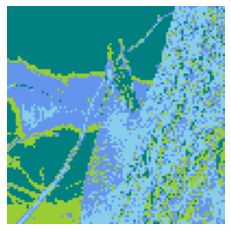

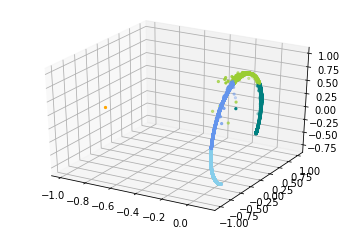


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 6
k-means : (k = 6, kmeanspp)  is converged at iter 15


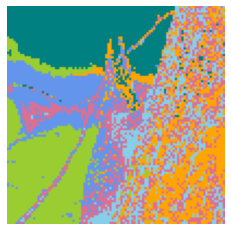

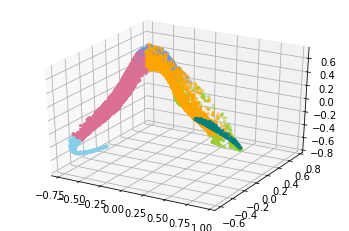

Spectral_clustering ratiocut with k = 6
k-means : (k = 6, kmeanspp)  is converged at iter 26


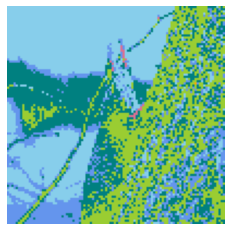

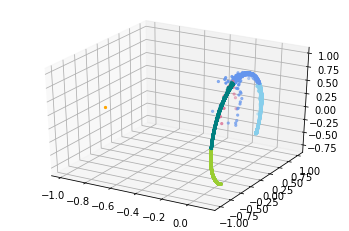


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 7
k-means : (k = 7, kmeanspp)  is converged at iter 21


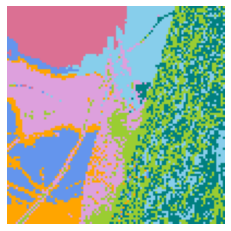

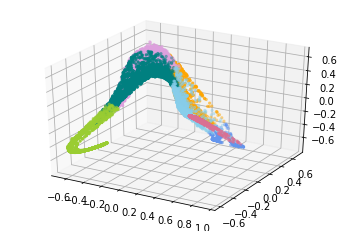

Spectral_clustering ratiocut with k = 7
k-means : (k = 7, kmeanspp)  is converged at iter 28


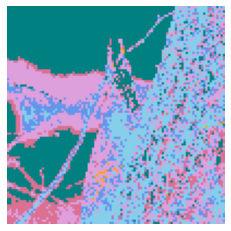

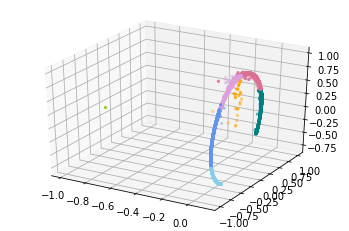


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 8
k-means : (k = 8, kmeanspp)  is converged at iter 81


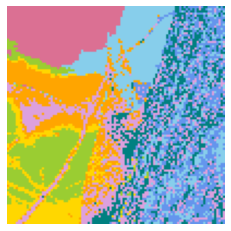

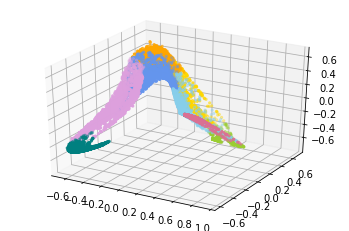

Spectral_clustering ratiocut with k = 8
k-means : (k = 8, kmeanspp)  is converged at iter 53


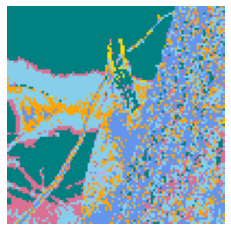

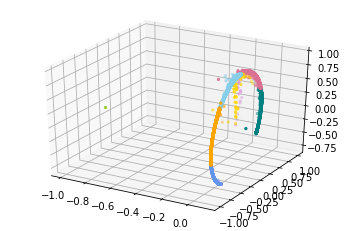


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 9
k-means : (k = 9, kmeanspp)  is converged at iter 27


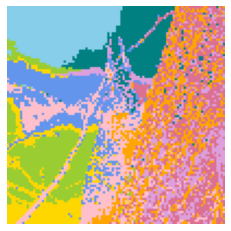

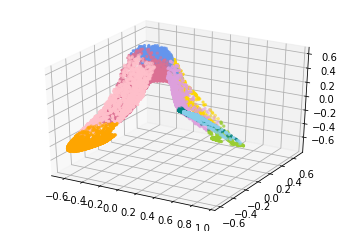

Spectral_clustering ratiocut with k = 9
k-means : (k = 9, kmeanspp)  is converged at iter 52


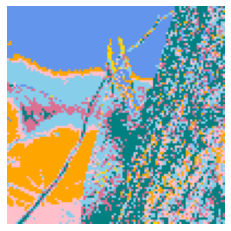

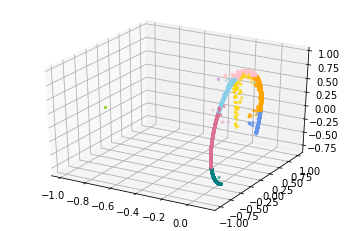


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 10
k-means : (k = 10, kmeanspp)  is converged at iter 30


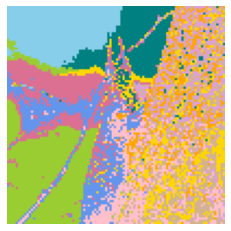

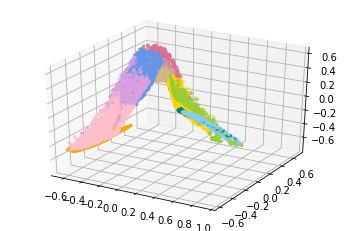

Spectral_clustering ratiocut with k = 10
k-means : (k = 10, kmeanspp)  is converged at iter 40


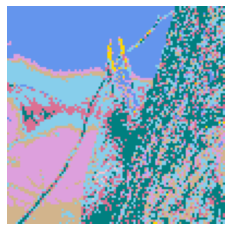

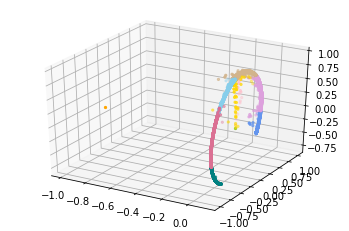


-----------------------------------------------------------------------------



In [12]:
kmeans_method = 'kmeanspp'
train_mode = True
for i, similarity in enumerate(kernals):
    for k in range(2, 11):
        params = {'root': f'img{i+1}',
                  'normalized': False,
                  'train_mode': train_mode,
                  'kmeans_method': kmeans_method}

        for cut_method in ['normalized', 'ratio'] :
            print(bashc.RED + f'Spectral_clustering {cut_method}cut with k = {k}' + bashc.ENDC)
            
            # set the parameters
            params['normalized'] = True if cut_method == 'normalized' else False
            filename = f'output_spectral/img{i+1}_{cut_method}({kmeans_method}={k})'
            # train the model
            model = spectral_clustering(similarity, k, params)
            records, eig_vals, eig_vecs = model.train()
            # visualization
            visualize_clusters(records, filename+'.gif')
            visualize_eigvecs(eig_vecs, records[-1], k, filename+'.png')
        print('\n-----------------------------------------------------------------------------\n')

### spectral clustering with kernal e-3e-4

Spectral_clustering normalizedcut with k = 10
k-means : (k = 10, kmeanspp)  is converged at iter 23


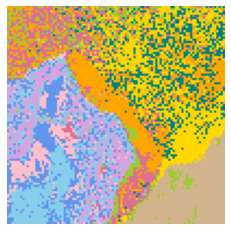

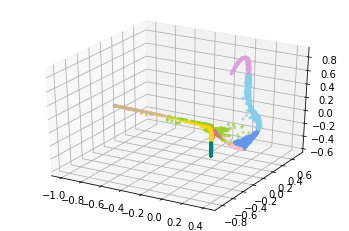

Spectral_clustering ratiocut with k = 10
k-means : (k = 10, kmeanspp)  is converged at iter 72


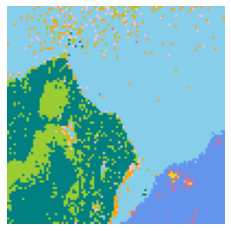

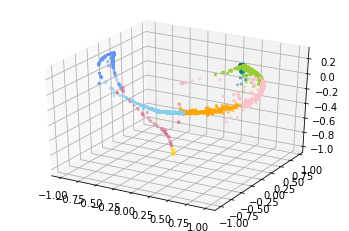


-----------------------------------------------------------------------------

Spectral_clustering normalizedcut with k = 10
k-means : (k = 10, kmeanspp)  is converged at iter 35


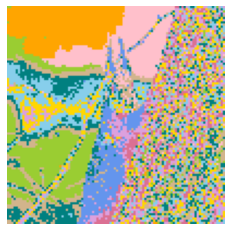

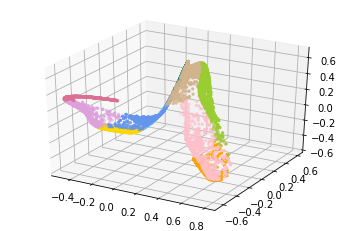

Spectral_clustering ratiocut with k = 10
k-means : (k = 10, kmeanspp)  is converged at iter 43


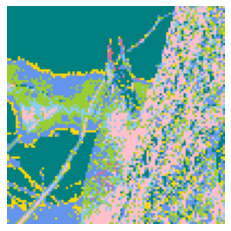

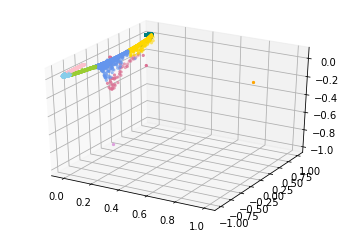


-----------------------------------------------------------------------------



In [17]:
kmeans_method = 'kmeanspp'
train_mode = True
for i, similarity in enumerate(kernals_e4e3):
    for k in range(10, 11):
        params = {'root': f'img{i+1}',
                  'normalized': False,
                  'train_mode': train_mode,
                  'kmeans_method': kmeans_method}

        for cut_method in ['normalized', 'ratio'] :
            print(bashc.RED + f'Spectral_clustering {cut_method}cut with k = {k}' + bashc.ENDC)
            
            # set the parameters
            params['normalized'] = True if cut_method == 'normalized' else False
            filename = f'output_spectral/e4e3/img{i+1}_{cut_method}({kmeans_method}={k})'
            # train the model
            model = spectral_clustering(similarity, k, params)
            records, eig_vals, eig_vecs = model.train()
            # visualization
            visualize_clusters(records, filename+'.gif')
            visualize_eigvecs(eig_vecs, records[-1], k, filename+'.png')
        print('\n-----------------------------------------------------------------------------\n')

### additional experiment

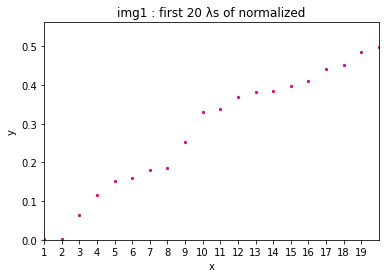

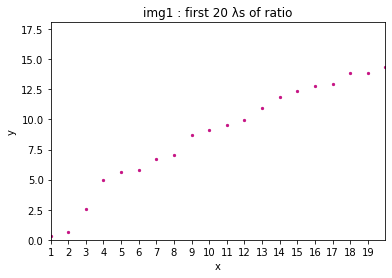

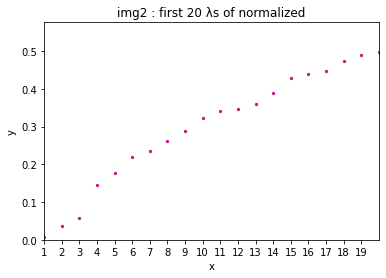

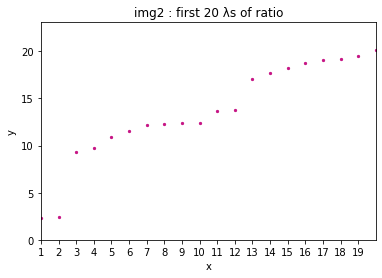

In [69]:
# (additional experiment : visualize the eigenvalues λ)
for eig_path in ['img1', 'img2']:
    for cut in ['normalized', 'ratio']:
        val_path = f'{eig_path}/{cut}_eig_vals_k.npy'
        eig_vals = np.load(val_path)
        plot_dot(np.arange(len(eig_vals)), eig_vals, f'{eig_path} : first 20 λs of {cut}')

## Combine gifs for report

In [76]:
for i in range(1, 3):
  for j in range(9):
      k = j + 2
      fs = []
      fs.append(imageio.get_reader(f'output_kmeans/img{i}_kmeans(k={k}).gif'))
      fs.append(imageio.get_reader(f'output_kmeans/img{i}_kmeans++(k={k}).gif'))
      fs.append(imageio.get_reader(f'output_spectral/img{i}_ratio(k={k}).gif'))
      fs.append(imageio.get_reader(f'output_spectral/img{i}_ratio(kmeanspp={k}).gif'))
      fs.append(imageio.get_reader(f'output_spectral/img{i}_normalized(k={k}).gif'))
      fs.append(imageio.get_reader(f'output_spectral/img{i}_normalized(kmeanspp={k}).gif'))
      number_of_frames = 100
    
      # Create writer object
      new_gif = imageio.get_writer(f'gif/img{i}/k={k}.gif')

      for frame_number in range(number_of_frames):
          imgs = []
          for d in range(6):
              imgs.append(fs[d].get_next_data())
          new_image = np.hstack((imgs[0], imgs[1], imgs[2], imgs[3], imgs[4], imgs[5]))
          new_gif.append_data(new_image)
      
      for d in range(6):
          fs[d].close()

      new_gif.close()